In [1]:
import os
from pathlib import Path
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
import timm
import cv2
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, classification_report)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#set up dataset roots
DATA_ROOT = Path("data/tree")
TRAIN_DIR = DATA_ROOT / "train"
TEST_DIR = DATA_ROOT / "test"
VAL_DIR = DATA_ROOT / "val"

IMG_SIZE = 224
BATCH_SIZE = 64
NUM_WORKERS = 0
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [3]:
#CLAHE (Contrast-Limited Adaptive Histogram Equalization) transform is really good on tress since trees contrast greatly with the background, this "normalizes" the contrast making it more visible for the model

class CLAHETransform:
    """ Enhance image contrast with CLAHE"""

    def __init__(self, clip_limit = 2.0, tile_grid_size = (8,8)):
        self.clip_limit = clip_limit
        self.title_grid_szie = tile_grid_size

    #actual call we will use to apply the transforms
    def __call__(self, img):
        img_np = np.array(img)

        #create a LAB image since RGB does not work with CLAHE
        lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
        #get luminance and a,b channels
        l,a,b = cv2.split(lab)

        #apply clahe on the luminance channel and merge it back
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.title_grid_szie)
        cl = clahe.apply(l)
        limg = cv2.merge((cl,a,b))

        finalImg = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

        return Image.fromarray(finalImg)

#create a letterbox resize to ensure aspect ratio is maintained
class LetterBoxResize:
    """ Resize an image with letterboxing to keep aspect ratio"""

    def __init__(self, size):
        self.size = size 
    
    def __call__(self, img):
        img.thumbnail((self.size, self.size), Image.Resampling.LANCZOS)

        #create a new bg, black for now
        new_img = Image.new("RGB", (self.size, self.size), (0,0,0))

        #paste the resized image into the center
        new_img.paste(img, ((self.size - img.size[0]) // 2,
                            (self.size - img.size[1]) // 2))
    
        return new_img
        
        


In [4]:
#set up transforms and dataloaders
train_transform = transforms.Compose([
    #custom augs
    LetterBoxResize(IMG_SIZE),
    CLAHETransform(clip_limit = 3.0),
    
    #torchvision augs
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.08, 0.08, 0.08, 0.02),

    #final prep
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    LetterBoxResize(IMG_SIZE),
    CLAHETransform(clip_limit = 3.0),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds = ImageFolder(TRAIN_DIR, transform = train_transform)
val_ds = ImageFolder(VAL_DIR, transform=val_transform)
test_ds = ImageFolder(TEST_DIR, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True, num_workers= NUM_WORKERS)
val_loader = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False, num_workers= NUM_WORKERS)
test_loader = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False, num_workers= NUM_WORKERS)


class_names = train_ds.classes
num_classes = len(class_names)
print("Classes:", class_names)
print("Class Count:", num_classes)
print("Sizes of Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))

Classes: ['Acer palmatum', 'Cedrus deodara', 'Celtis sinensis', 'Cinnamomum camphora (Linn) Presl', 'Elaeocarpus decipiens', 'Flowering cherry', 'Ginkgo biloba', 'Koelreuteria paniculata', 'Lagerstroemia indica', 'Liquidambar formosana', 'Liriodendron chinense', 'Magnolia grandiflora L', 'Magnolia liliflora Desr', 'Michelia chapensis', 'Osmanthus fragrans', 'Photinia serratifolia', 'Platanus', 'Prunus cerasifera f. atropurpurea', 'Salix babylonica', 'Sapindus saponaria', 'Styphnolobium japonicum', 'Triadica sebifera', 'Zelkova serrata']
Class Count: 23
Sizes of Train: 3850 Val: 482 Test: 472


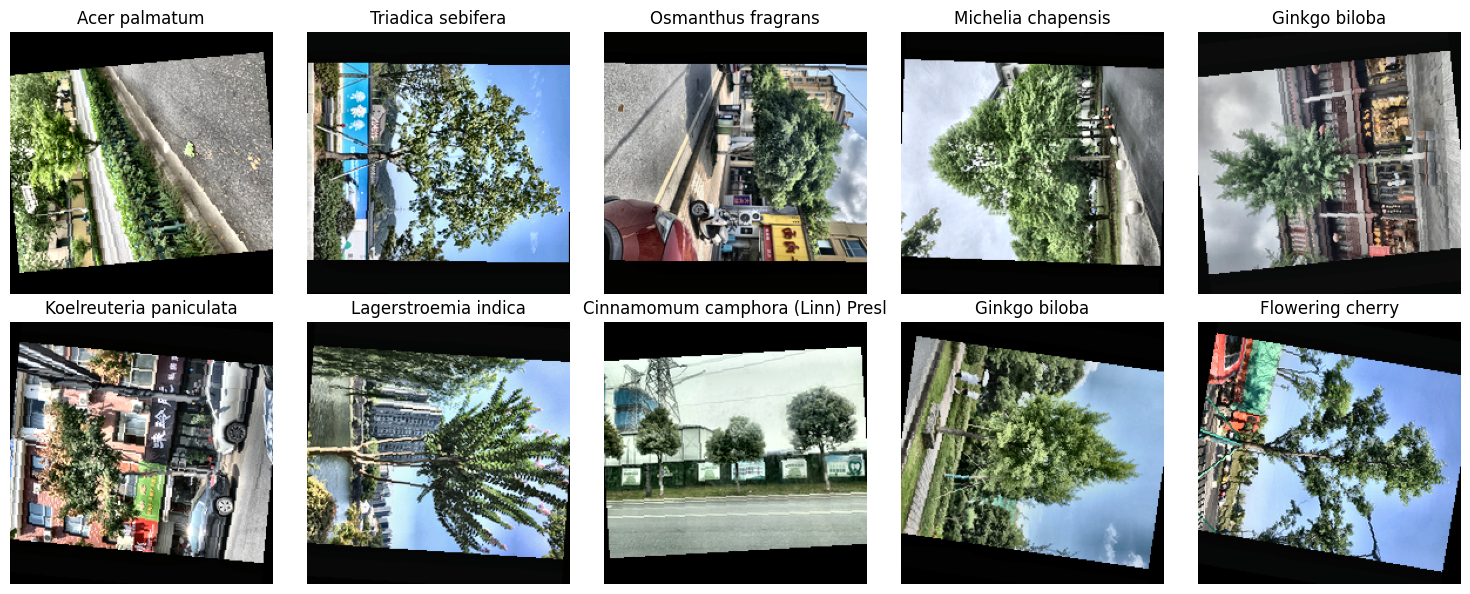

In [5]:
#show a bacth of the preprocessed images
def show_batch(loader, num_images = 10):
    #grab a single batch from the loader
    images, labels = next(iter(loader))

    #setup a plot
    fig, axes = (plt.subplots(num_images//5, 5, figsize =  (15,6)))
    axes = axes.flatten()

    #denorm
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i in range(num_images):
        img = images[i].numpy().transpose((1,2,0)) #Change from (C, H, W) to (H, W, C)
        img = std * img + mean #denorm
        img = np.clip(img, 0, 1) #force vals between 0 and 1

        axes[i].imshow(img)
        axes[i].set_title(class_names[labels[i]])
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


show_batch(train_loader)